#### Option 2: Loading image data with a custom `Dataset`

1. Be able to load images from files
2. Be able to get class names from the Dataset
3. Be able to get classes as dictionary (key < str>: value < int>) from the Dataset

Pros:
* Can create a `Dataset` out of almost anything
* Not limited to PyTorch pre-built `Dataset` functions

Cons:
* Even though you could create a `Dataset` out of almost anything, it doesn't mean it will work...
* Using a custom `Dataset` often results in us writing more code, which could be time wasting, prone to errors, or leads to performance issues

All custom datasets in PyTorch, often inherit from the `Dataset` class.

In [2]:
import os
import pathlib
import torch
from PIL import Image
from torchvision import transforms
from typing import List, Tuple, Dict

In [3]:
os.getcwd()

'/home/arp/Documents/github/ml-pytorch'

In [9]:
# create a helper function to get the class names
# we can use `os.scandir` to traverse a directory (ideally the directory is in standard image
# classification format)
# raise error if class names are not found (could be due wrong dir structure)
# turn the class names into a list and a dictionary

In [6]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
  """Finds the class folders in a dataset.

  Assumes the directory structure is the following:
  * data/
    * dataset_name/
      * train/
        * class 1/
        * class 2/
        * ...
      * test/
        * class 1/
        * class 2/
        * ...

  Args:
    directory (str): directory where the dataset is stored

  Returns:
    Tuple[List[str], Dict[str, int]]: (classes, class_to_idx)
      classes (List[str]): list of class names
      class_to_idx (Dict[str, int]): dictionary with class names as keys  and class indices as values
  """
  
  classes = sorted([entry.name for entry in os.scandir(directory) if entry.is_dir()])
  
  if not classes:
    raise FileNotFoundError(f"Couldn't find any classes in {directory}.")
  
  class_to_idx = { class_name: i for i, class_name in enumerate(classes)}
  
  return classes, class_to_idx

In [13]:
target_dir = "./data/pizza_steak_sushi"

find_classes(target_dir + "/train")

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

#### Create a custom `Dataset` to replicate `ImageFolder`

To create our own custom dataset, we wnt to:

1. Subclass `torch.utils.data.Dataset`
2. Init our subclass with a target directory (the directory we'd like to get data from) as well as a transform if we'd like to transform our data.
3. Create several attributes:
    * paths - paths of our images
    * tansforms - the transform we'd like to use
    * classes - a list of the target classes
    * class_to_idx - a dictionary of the target classes mapped to integer labels
4. Create a function to `load_images()`, this function will open an image
5. Overwrite the `__len__()` (length) and `__getitem__()` (return a given sample when passed an index) methods

In [15]:
from torch.utils.data import Dataset

class ImageFolder(Dataset):
  def __init__(self, root: str, transform=None):
    self.paths = list(pathlib.Path(root).glob("**/*.jpg"))
    self.transform = transform
    self.classes, self.class_to_idx = find_classes(root)
  
  def load_image(self, index: int) -> Image.Image:
    """Opens an image via a path and returns it.

    Args:
      index (int): index of the image to be loaded from self.paths

    Returns:
      Image.Image: Image object
    """
    image = Image.open(self.paths[index])
    return image
  
  def __len__(self) -> int:
    return len(self.paths)
  
  def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
    image = self.load_image(index)
    class_name = self.paths[index].parent.name
    class_idx = self.class_to_idx[class_name]
    
    if self.transform:
      image = self.transform(image)

    return image, class_idx

In [11]:
train_transform = transforms.Compose([
  transforms.Resize((224, 224)),
  transforms.RandomHorizontalFlip(0.5),
  transforms.ToTensor(),
])

test_transform = transforms.Compose([
  transforms.Resize((224, 224)),
  transforms.ToTensor(),
])



In [17]:
train_data = ImageFolder(target_dir + "/train", transform=train_transform)
test_data = ImageFolder(target_dir + "/test", transform=test_transform)
train_data, test_data

(<__main__.ImageFolder at 0x7222e5b011f0>,
 <__main__.ImageFolder at 0x7223641afbc0>)

In [18]:
len(train_data), len(test_data)

(225, 75)

In [19]:
train_data.classes

['pizza', 'steak', 'sushi']

In [20]:
train_data.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

#### Create a helper function to visualize data

1. Take in a `Dataset` and a number of other parameters such as class names and how many images to visualize.
2. To prevent the display getting out of hand, let's cap the number of images to see at 10.
3. Set the random seed for reproducibility
4. Get a list of random samples indexes from the target dataset
5. setup a matplotlib figure
6. Loop through the random sample images and plot them

In [29]:
range(len(train_data))

range(0, 225)

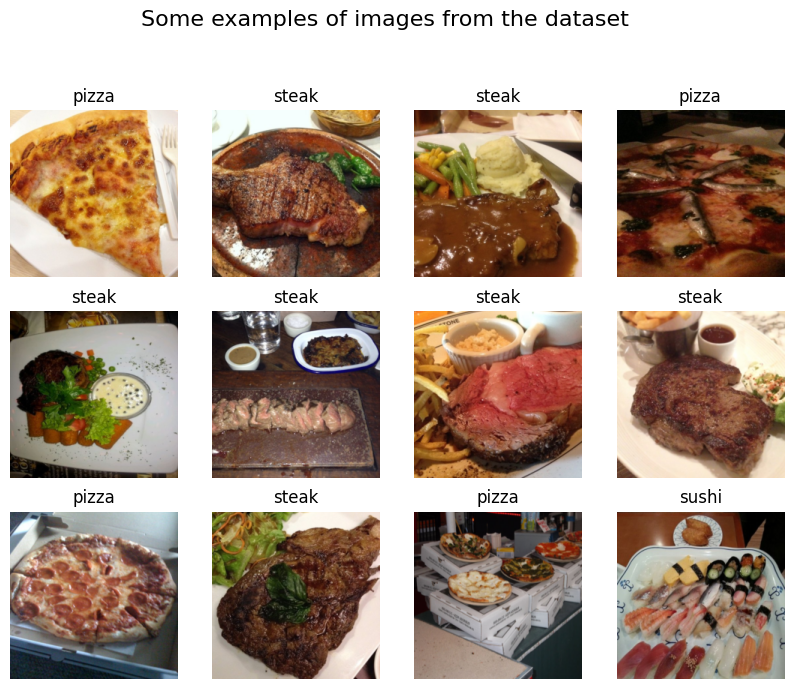

In [33]:
import matplotlib.pyplot as plt
import random

def display_examples(data: Dataset, classes: List[str], n: int, seed: int = 42):
  random.seed(seed)
  random_samples = random.sample(range(len(data)), n)
  fig = plt.figure(figsize=(10, 10))
  fig.suptitle("Some examples of images from the dataset", fontsize=16)
  for i, img_idx in enumerate(random_samples):
    img, class_idx = data[img_idx]
    ax = fig.add_subplot(4, 4, i + 1)
    ax.axis(False)
    ax.imshow(img.permute(1, 2, 0)) # [1st] -> img index, [2nd] -> img tensor
    ax.set_title(classes[class_idx])

display_examples(train_data, train_data.classes, 12)

In [36]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_data, batch_size=32, shuffle=True, num_workers=os.cpu_count())
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=False)
train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x72229ebcc290>,
 <torch.utils.data.dataloader.DataLoader at 0x72229c8d45f0>)

In [38]:
batch, batch_labels = next(iter(train_dataloader))
batch.shape, batch_labels.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32]))